# FAKE NEWS PROJ DRAFT 1

In [24]:
# Lots of help and code and inspiration from Andrii Shchur's three part blog post
# https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052
# https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-ii-modeling-42b9f901b12b
# https://medium.com/analytics-vidhya/fake-news-detector-with-deep-learning-approach-part-iii-deploy-292be3be7950

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Dense, LSTM, Input,GlobalMaxPool1D,Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Embedding, Input,GlobalMaxPool1D,Dropout,concatenate
from tensorflow.keras.models import Model, Sequential

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

import pydot
import os

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
!ls fake_news

submit.csv test.csv   train.csv


In [28]:
data = pd.read_csv("fake_news/train.csv")

In [29]:
data = data[['title', "text","label"]].dropna()
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [30]:
data[0:1].title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

## Process Data

In [31]:
#Get the Depndent feature
X = data.drop('label',axis=1)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53421)

In [32]:
# X_train.shape

In [33]:
vo_size = 500
messages = X_train.copy()
messages.reset_index(inplace=True)

In [34]:
messages

,index,title,text
0,10647,It Was The Devil vs. The Loch Ness Monster,"Financial Markets , Gold , Market Manipulation..."
1,5869,Comment on NSA Whistleblower: ‘NSA Has ALL of ...,Home / Be The Change / NSA Whistleblower: ‘NSA...
2,16754,Google to Get Fiat Chrysler Minivans for Self-...,DETROIT — The development of cars in rece...
3,16812,Comment on Predetermined vote counts show Nov....,Dr. Eowyn | 2 Comments WARNING: \nThis post ...
4,13042,The US Elections Do Matter But Not Necessary T...,"By Rixon Stewart on September 12, 2006 \nIs te..."
...,...,...,...
16157,17043,Astronomers Think They Have Just Discovered Me...,The Daily Sheeple \nby Jake Anderson \nAnomalo...
16158,2769,Putin Responds to Claims He’s Undermining US D...,Migrant Crisis Disclaimer \nWe here at the Dai...
16159,8624,Turkey Seeks to Rid Education of Erdogan Oppon...,ISTANBUL — The Turkish authorities extended...
16160,17005,Culture War – The ‘Have Mores’ Mock DAPL Prote...,Waking Times \nMore evidence emerges that a cu...


In [35]:
ps_title = PorterStemmer()
ps_text = PorterStemmer()
corpus_title = []
corpus_text = []

for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

In [36]:
# One hot representation
onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

In [37]:
# sequences representation
sent_length_title = 20
sent_length_text = 1000
embedded_doc_title = pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text = pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

In [38]:

print(len(embedded_doc_title),y_train.shape)
print(len(embedded_doc_text),y_train.shape)

16162 (16162,)
16162 (16162,)


In [39]:
# final data for NN
X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
y_final=np.array(y_train)
print(X_final_title.shape,y_final.shape)
print(X_final_text.shape,y_final.shape)

(16162, 20) (16162,)
(16162, 1000) (16162,)


In [125]:
# test
messages=X_test.copy()
messages.reset_index(inplace=True)

ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
print(X_final_title.shape)
print(X_final_text.shape)


(4041, 20)40 / 4041
(4041, 1000)


## Building Model

In [40]:

embedding_vector_feature_title = 10
embedding_vector_feature_text = 100

input_title = Input(shape=(sent_length_title,))
input_text = Input(shape=(sent_length_text,))

emb_title = Embedding(vo_size, embedding_vector_feature_title)(input_title)
lstm_title = LSTM(128, return_sequences=False)(emb_title)

emb_text = Embedding(vo_size, embedding_vector_feature_text)(input_text)
lstm_text = LSTM(128, return_sequences=True)(emb_text)

max_pool_text = GlobalMaxPool1D()(lstm_text)
dropout_1_text = Dropout(0.1)(max_pool_text)
dense_1_text = Dense(50, activation='relu')(dropout_1_text)
dropout_2_text = Dropout(0.1)(dense_1_text)

out = concatenate([lstm_title,dropout_2_text],axis=-1)
output=Dense(1, activation='sigmoid')(out)

model = Model(inputs=[input_title, input_text], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 100)    50000       ['input_4[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 1000, 128)    117248      ['embedding_3[0][0]']            
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 128)         0           ['lstm_3[0][0]']                 
 MaxPooling1D)                                                                              

In [45]:
model

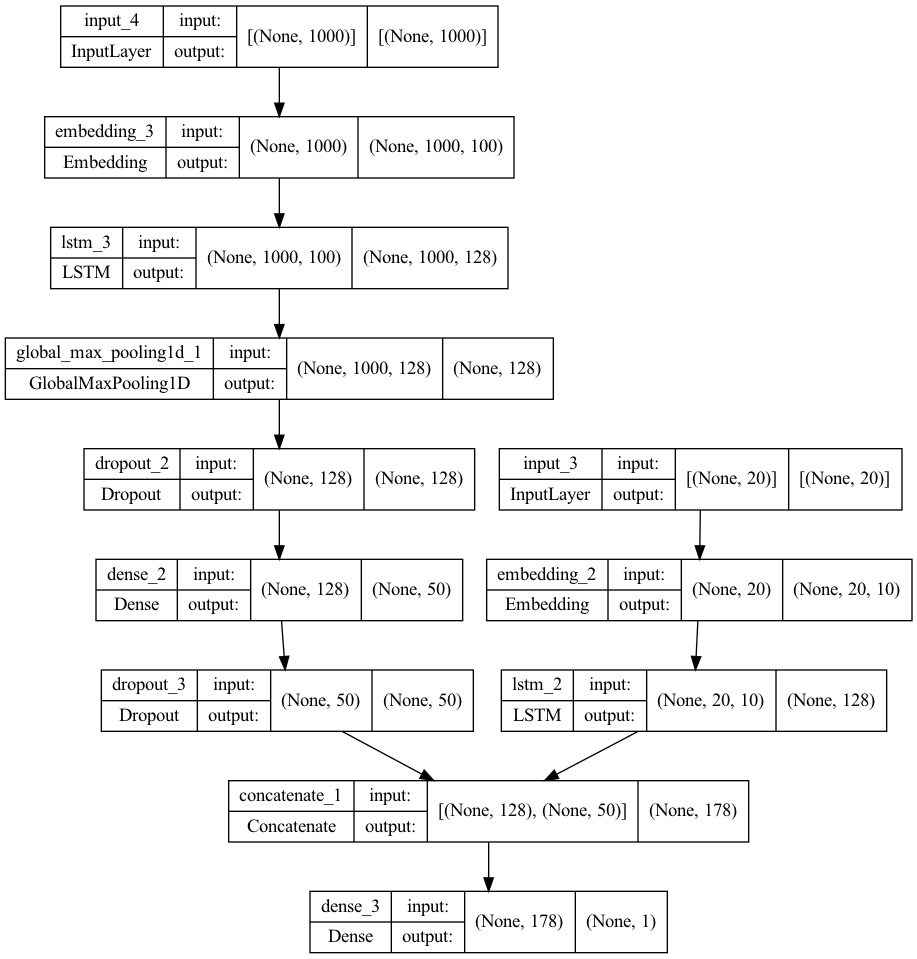

In [41]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Training and saving training with checkpoints

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [130]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [131]:
history = model.fit(x=[X_final_title,X_final_text], y=y_final, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[cp_callback])



Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 1.5565 - accuracy: 0.4929
Epoch 1: saving model to training_1/cp.ckpt
26/26 [==============================] - 36s 1s/step - loss: 1.5565 - accuracy: 0.4929 - val_loss: 0.7675 - val_accuracy: 0.5019
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.5006
Epoch 2: saving model to training_1/cp.ckpt
26/26 [==============================] - 17s 665ms/step - loss: 0.7400 - accuracy: 0.5006 - val_loss: 0.7118 - val_accuracy: 0.5105
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5189
Epoch 3: saving model to training_1/cp.ckpt
26/26 [==============================] - 16s 622ms/step - loss: 0.7036 - accuracy: 0.5189 - val_loss: 0.6995 - val_accuracy: 0.5155
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5297
Epoch 4: saving model to training_1/cp.ckpt
26/26 [==============================] - 16s 626ms/step

In [132]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001', 'checkpoint', 'cp.ckpt.index']

## Testing Model

In [133]:
# X_test, y_test

In [68]:
y_pred_final = model.predict ([X_final_title,X_final_text])


In [108]:
y_prob = pd.DataFrame(y_pred_final)
y_prob['0'] = 1 - y_prob[0]
y_class = pd.DataFrame(y_prob.values.argmax(axis=-1))
y_class[0] = np.where(y_class[0]==1, 0, 1)
y_class.head()

,0
0,1
1,1
2,0
3,1
4,1


In [109]:
accuracy_score(y_test, y_class)

0.8869091808958178

## Serialize model and create a function to take a website and leverage out model 

In [122]:
model.save('model/model1')
print('Model Saved!')

2022-05-15 16:27:21.820856: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/model1/assets


INFO:tensorflow:Assets written to: model/model1/assets


Model Saved!


In [123]:
model.save_weights("weights/weights1")
print('Weights Saved!')

Weights Saved!
